# High Rayleigh number resolution tests, continued

In [85]:
import importlib

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask

from modules import stats
import modules.regridding

importlib.reload(stats)
importlib.reload(regridding)

from modules.regridding import Regridder

## Model runs

In [30]:
nx0 = 1024
nz0 = 128
dt0 = 2e-3
alpha = 8

nx = np.array([256, 384, 512, 768, 1024])
nz = np.array([128])
nx, nz = np.meshgrid(nx, nz)
dt = (nx0/alpha + nz0)/(nx/alpha + nz)*dt0
dt = np.round(dt*1e3, 2)

print('(N_x, N_z, dt):')
print(np.array(list(zip(nx.flat, nz.flat, dt.flat))))

(N_x, N_z, dt):
[[ 256.    128.      3.2 ]
 [ 384.    128.      2.91]
 [ 512.    128.      2.67]
 [ 768.    128.      2.29]
 [1024.    128.      2.  ]]


In [52]:
data = {}
for nx in [256, 384, 512, 768]:
    name = f'{nx}_128/*.nc'
    ds = xr.open_mfdataset(f'../data/restest_highRa_v2/{name}')
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.drop_duplicates('t')
    data[(nx, 128)] = ds

ds = xr.open_mfdataset('../data/highRa_tests/nonlinear_hyper_test/*.nc')
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = ds.drop_duplicates('t')
data[(1024, 128)] = ds

## Statistics

In [101]:
nx = [256, 384, 512, 768, 1024]
nz = [128]
w_quantiles = xr.DataArray(
    name='quantiles',
    coords={'nx': nx, 'nz': nz},
    dims=['nx', 'nz'],
)
theta_quantiles = w_quantiles.copy()
for res in data.keys():
    regridder = Regridder(data[res], data[(256, 128)], ('x',))
    t_range = (data[res].t[-1] - 50., data[res].t[-1])
    w_quantile = stats.level_quantile(
        data[res].w, 0.5, 0.99, t_range, regridder)
    theta_quantile = stats.level_quantile(
        data[res].theta, 0.5, 0.99, t_range, regridder)
    w_quantiles.loc[dict(nx=res[0], nz=res[1])] = w_quantile
    theta_quantiles.loc[dict(nx=res[0], nz=res[1])] = theta_quantile

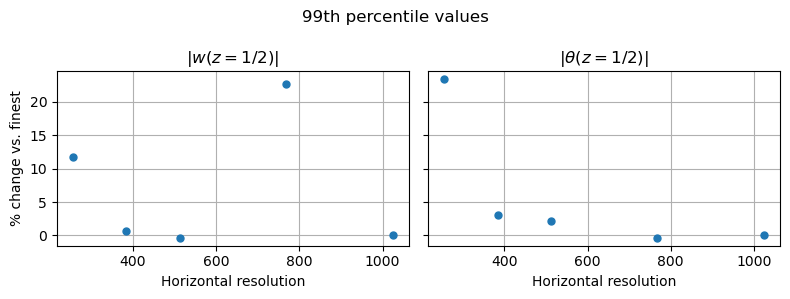

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

da = w_quantiles.sel(nz=128)
da = (da/da.sel(nx=1024) - 1)*1e2
axes[0].plot(da.nx, da, '.', markersize=10)
axes[0].grid()
axes[0].set(
    xlabel='Horizontal resolution',
    ylabel=r'% change vs. finest',
    title=r'$|w(z=1/2)|$',
)

da = theta_quantiles.sel(nz=128)
da = (da/da.sel(nx=1024) - 1)*1e2
axes[1].plot(da.nx, da, '.', markersize=10)
axes[1].grid()
axes[1].set(
    xlabel='Horizontal resolution',
    title=r'$|\theta(z=1/2)|$')

fig.suptitle('99th percentile values')
fig.tight_layout()